# Zugriffsdaten-Analyse

In diesem Notebook analysieren wir eine Logdatei mit Zugriffsdaten eines Webserver von einem iranischen Online-Shop. Wir wollen anhand der Zugriffsdaten herausfinden, welche Produkte des Online-Shops am beliebtesten sind. Außerdem untersuchen wir die Daten auf weitere Auffälligkeiten.

## Setup

Als erstes verbinden wir uns mit dem Spark Master Node. Den erreichen wir unter der URL `spark://localhost:7077`.

In [1]:
import pyspark
from pyspark.sql.functions import *

spark = pyspark.sql.SparkSession.builder.appName("main") \
  .master("spark://localhost:7077") \
  .config("spark.executor.memory", "8G") \
  .getOrCreate()

22/06/29 21:20:39 WARN Utils: Your hostname, Pauls-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
22/06/29 21:20:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/29 21:20:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Datenimport

Als nächstes importieren wir die Datei `access.log`.

In [2]:
raw_df = spark.read.csv("/tmp/data/access.log", sep=" ")

In [45]:
raw_df.count()

22/06/29 20:43:16 ERROR TaskSchedulerImpl: Lost executor 13 on 172.26.0.3: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/06/29 20:43:16 WARN TaskSetManager: Lost task 8.0 in stage 33.0 (TID 292) (172.26.0.3 executor 13): ExecutorLostFailure (executor 13 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/06/29 20:43:16 WARN TaskSetManager: Lost task 10.0 in stage 33.0 (TID 294) (172.26.0.3 executor 13): ExecutorLostFailure (executor 13 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.


10365152

In [3]:
raw_df.rdd.getNumPartitions()

27

In [20]:
raw_df.show(5)

+-------------+---+---+--------------------+------+--------------------+---+-----+--------------------+--------------------+----+
|          _c0|_c1|_c2|                 _c3|   _c4|                 _c5|_c6|  _c7|                 _c8|                 _c9|_c10|
+-------------+---+---+--------------------+------+--------------------+---+-----+--------------------+--------------------+----+
| 54.36.149.41|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /filter/27|13...|200|30577|                   -|Mozilla/5.0 (comp...|   -|
|  31.56.96.51|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /image/60844/...|200| 5667|https://www.zanbi...|Mozilla/5.0 (Linu...|   -|
|  31.56.96.51|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /image/61474/...|200| 5379|https://www.zanbi...|Mozilla/5.0 (Linu...|   -|
|40.77.167.129|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /image/14925/...|200| 1696|                   -|Mozilla/5.0 (comp...|   -|
|  91.99.72.15|  -|  -|[22/Jan/2019:03:5...|+0330]|GET /product/3189...|200|41483|        

Die Kopfzeile der `DataFrame`-Tabelle enthält noch keine sinnvollen Bezeichnungen. Das wollen wir jetzt ändern.

In [4]:
df = raw_df.withColumnRenamed("_c0", "ip") \
  .drop("_c1") \
  .withColumnRenamed("_c2", "user") \
  .withColumnRenamed("_c3", "timestamp") \
  .withColumnRenamed("_c4", "timezone") \
  .withColumnRenamed("_c5", "request_line") \
  .withColumnRenamed("_c6", "status") \
  .withColumnRenamed("_c7", "bytes_sent") \
  .withColumnRenamed("_c8", "referer") \
  .withColumnRenamed("_c9", "user_agent") \
  .drop("_c10")

In [24]:
df.show(5)

+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
|           ip|user|           timestamp|timezone|        request_line|status|bytes_sent|             referer|          user_agent|
+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
| 54.36.149.41|   -|[22/Jan/2019:03:5...|  +0330]|GET /filter/27|13...|   200|     30577|                   -|Mozilla/5.0 (comp...|
|  31.56.96.51|   -|[22/Jan/2019:03:5...|  +0330]|GET /image/60844/...|   200|      5667|https://www.zanbi...|Mozilla/5.0 (Linu...|
|  31.56.96.51|   -|[22/Jan/2019:03:5...|  +0330]|GET /image/61474/...|   200|      5379|https://www.zanbi...|Mozilla/5.0 (Linu...|
|40.77.167.129|   -|[22/Jan/2019:03:5...|  +0330]|GET /image/14925/...|   200|      1696|                   -|Mozilla/5.0 (comp...|
|  91.99.72.15|   -|[22/Jan/2019:03:5...|  +0330]|GET /product/3189...|   20

Dann sollten wir noch die Inhalte innerhalb der Zellen bereinigen. Momentan werden leere Zellen mit einem Bindestrich gekennzeichnet. Wir wollen diese Bindestriche entfernen. Außerdem enthalten die Zellen der Spalten `timestamp` und `timezone` unnötige Symbole. Diese wollen wir auch entfernen.

In [5]:
df = df.withColumn("user", regexp_replace("user", "-", "")) \
  .withColumn("timestamp", regexp_replace("timestamp", "^\[", "")) \
  .withColumn("timezone", regexp_replace("timezone", "\]$", "")) \
  .withColumn("referer", regexp_replace("referer", "-", ""))

In [27]:
df.show(5)

+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
|           ip|user|           timestamp|timezone|        request_line|status|bytes_sent|             referer|          user_agent|
+-------------+----+--------------------+--------+--------------------+------+----------+--------------------+--------------------+
| 54.36.149.41|    |22/Jan/2019:03:56:14|   +0330|GET /filter/27|13...|   200|     30577|                    |Mozilla/5.0 (comp...|
|  31.56.96.51|    |22/Jan/2019:03:56:16|   +0330|GET /image/60844/...|   200|      5667|https://www.zanbi...|Mozilla/5.0 (Linu...|
|  31.56.96.51|    |22/Jan/2019:03:56:16|   +0330|GET /image/61474/...|   200|      5379|https://www.zanbi...|Mozilla/5.0 (Linu...|
|40.77.167.129|    |22/Jan/2019:03:56:17|   +0330|GET /image/14925/...|   200|      1696|                    |Mozilla/5.0 (comp...|
|  91.99.72.15|    |22/Jan/2019:03:56:17|   +0330|GET /product/3189...|   20

Uns fällt auf, dass die Spalte `request_line` in zwei Spalten aufgeteilt werden kann. Sie enthält nämlich zum einen die Information darüber, welche HTTP-Methode in einer Anfrage verwendet wurde, und zum anderen den URL-Pfad mit Query-Parametern. Wir wollen die Spalte `request_line` in die Spalten `method` und `request_path` aufteilen.

In [6]:
request_line_split = split(df.request_line, " ")
df = df.withColumn("method", request_line_split.getItem(0)) \
  .withColumn("request_path", request_line_split.getItem(1))

In [29]:
df.select("request_line", "method", "request_path").show(5)

+--------------------+------+--------------------+
|        request_line|method|        request_path|
+--------------------+------+--------------------+
|GET /filter/27|13...|   GET|/filter/27|13%20%...|
|GET /image/60844/...|   GET|/image/60844/prod...|
|GET /image/61474/...|   GET|/image/61474/prod...|
|GET /image/14925/...|   GET|/image/14925/prod...|
|GET /product/3189...|   GET|/product/31893/62...|
+--------------------+------+--------------------+
only showing top 5 rows



In [7]:
df = df.drop("request_line")

## Beliebteste Produkte

Wir gehen von der Annahme aus, dass die Beliebtheit eines Produkts von der Anzahl der Anfragen an das Produkt abgeleitet werden kann. Diese Metrik kann zwar leicht durch äußere Einwirkungen manipuliert werden, aber diese Tatsache ignorieren wir im Rahmen dieser Aufgabe.

Als erstes wollen wir herausfinden, welche Anfragen auf ein bestimmtes Produkt bezogen sind. Dafür fügen wir in unserem `DataFrame` eine weitere Spalte `product_id` hinzu, in der die Produkt-ID der Anfragen steht, die einen Anfragepfad im Schema `/product/<product-id>` besitzen.

In [16]:
df = df.withColumn("product_id", regexp_extract("request_path", r'^/product/(\d+)', 1))

In [28]:
df.select("request_path", "product_id").filter(df.product_id != "").show(10)

+--------------------+----------+
|        request_path|product_id|
+--------------------+----------+
|/product/31893/62...|     31893|
|      /product/10214|     10214|
|/product/10075/13...|     10075|
|      /product/14926|     14926|
|/product/32798/63...|     32798|
|/product/30649?mo...|     30649|
|/product/7793/966...|      7793|
|      /product/81900|     81900|
|/product/4057/47/...|      4057|
|/product/29080?mo...|     29080|
+--------------------+----------+
only showing top 10 rows



Wenn wir jetzt die Zeilen der Tabelle nach der der Produkt-ID gruppieren, die Anzahl der Reihen für jede Gruppe berechnen und die Gruppen nach dieser Anzahl sortieren, können wir die Anzahl der Anfragen für jedes Produkt auslesen.

In [19]:
product_group_df = df.filter(df.product_id != "").groupBy("product_id").count().sort(col("count").desc()).limit(50).toPandas()

22/06/29 21:43:35 ERROR TaskSchedulerImpl: Lost executor 2 on 172.29.0.2: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/06/29 21:43:35 WARN TaskSetManager: Lost task 17.0 in stage 17.0 (TID 157) (172.29.0.2 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.
22/06/29 21:43:35 WARN TaskSetManager: Lost task 16.0 in stage 17.0 (TID 156) (172.29.0.2 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Remote RPC client disassociated. Likely due to containers exceeding thresholds, or network issues. Check driver logs for WARN messages.


In [21]:
product_group_df.head()

,product_id,count
0,33953,764
1,34286,738
2,33968,693
3,33954,687
4,33956,594


<AxesSubplot:xlabel='product_id'>

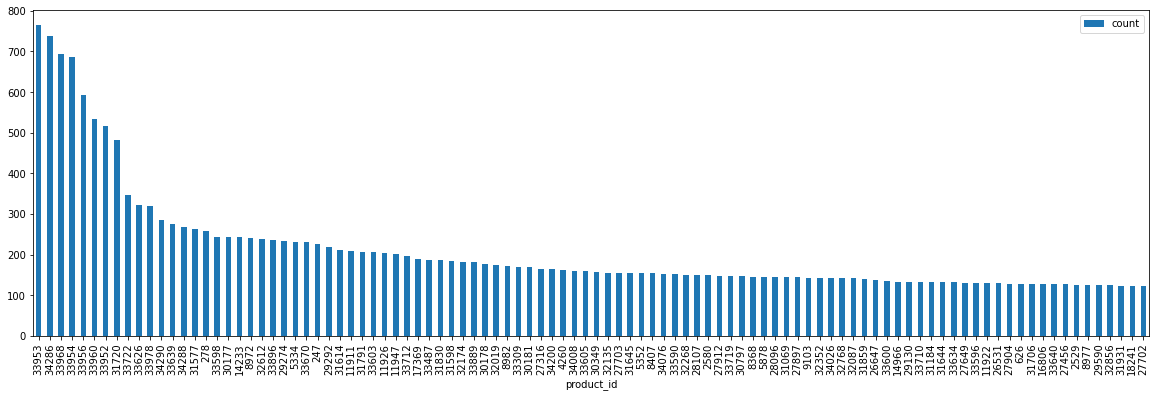

In [29]:
product_group_df.plot.bar(figsize=(20, 6), x="product_id")